In [195]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from spkit.simulate_student import SimulateStudent
from spkit import bkt, pfa
from sklearn.metrics import roc_curve, auc
import pandas as pd
import seaborn as sns
from tqdm import notebook as tqdm

### Simulate students

Create data

In [292]:
N_CONCEPTS = 3
N_QUESTIONS = 20
N_STUDENTS = 25
N_ATTEMPTS = 3

# Save original params: P_L0 P_T, P_S, P_G
bkt_params = np.zeros((N_CONCEPTS, 4))

# Create and fill Q Matrix (more than one concept per question)
q_matrix = np.random.rand(N_QUESTIONS, N_CONCEPTS)
q_matrix[q_matrix >= 0.5] = 1
q_matrix[q_matrix < 0.5] = 0
# If there is any zeroed column in the q matrix (question not belonging to concept), substitute it per 1
q_matrix[np.where(q_matrix.sum(axis=1) == 0)] = 1

# # Create and fill Q Matrix (just one concept per question)
# q_matrix = np.zeros((N_QUESTIONS, N_CONCEPTS))
# q_matrix[:,0] = np.random.rand(N_QUESTIONS)
# q_matrix[q_matrix >= 0.5] = 1
# q_matrix[q_matrix < 0.5] = 0
# q_matrix[:,1] = 1-q_matrix[:,0]

# Create and fill Q Matrix (just one concept)
# q_matrix = np.ones((N_QUESTIONS, N_CONCEPTS))
data = []

# Generate a BKT model for each concept
for concept in range(N_CONCEPTS):
    p_L0 = np.random.uniform(0.1, 0.3)
    p_T = np.random.uniform(0.1, 0.2)
    p_S = np.random.uniform(0.1, 0.3)
    p_G = np.random.uniform(0, 0.15)
    bkt_params[concept,:] = (p_L0, p_T, p_S, p_G)

#     data_time = []
#     students = SimulateStudent(p_L0, p_T, p_S, p_G, timestamp_prior)
    students = SimulateStudent(p_L0, p_T, p_S, p_G)
    for i in range(N_STUDENTS):
#         last_time = datetime(2019,12,17)
        answered_questions = []
        for question_id in range(N_QUESTIONS):
            # Check if question belongs to concept
            if q_matrix[question_id, concept] == 1:
                # Draw result
                new_attempt = True
                while new_attempt:
                    answered_questions.append(question_id)
                    new_attempt = np.random.binomial(1, 0.5)
        observations = students.simulate(len(answered_questions))
        for idx, question_id in enumerate(answered_questions):
            data.append([observations[idx], i, question_id])

        else:
            continue
data = np.asarray(data)
students = list(range(N_STUDENTS))

Separate in train and test

In [293]:
np.random.seed(1)
np.random.shuffle(students)

In [294]:
TRAIN_PROPORTION = 0.8
idx = int(np.ceil(TRAIN_PROPORTION*len(students)))
train_students = students[:idx]
test_students = students[idx:]

In [295]:
train_set = data[np.where(np.isin(data[:,1], train_students))]
test_set = data[np.where(np.isin(data[:,1], test_students))]

Some users will be used in training up to a certain number of attempts

In [296]:
# %%time
test_set = np.empty((0,3), int)
np.random.seed(1)
train_attempts = np.random.uniform(size=len(test_students))
for idx, student in enumerate(test_students):
    student_attempts = data[np.where(data[:,1] == student)]
    ta = int(np.floor(0.2*len(student_attempts)))
    train_set = np.vstack((train_set, data[np.where(data[:,1] == student)][:ta]))
    test_set  = np.vstack((test_set,  data[np.where(data[:,1] == student)][ta:]))

In [297]:
train_students = list(set(train_set[:,1]))
n_students = len(train_students)
n_questions = len(list(set(train_set[:,2])))

attempt_distribution = []
max_attempt = 0
for student in train_students:
    student_attempts = len(data[np.where(data[:,1] == student)])
    attempt_distribution.append(student_attempts)
    if student_attempts > max_attempt:
        max_attempt = student_attempts
        
median_attempt = int(np.median(np.asarray(attempt_distribution)))
student_performance = np.zeros((n_students, N_QUESTIONS, median_attempt))
X = np.zeros(student_performance.shape)

In [298]:
from collections import defaultdict

In [299]:
student_attempts = defaultdict(int)
for item in train_set:
    outcome, s_idx, q_idx = item
#     a_idx = student_attempts[(s_idx, q_idx)]
    a_idx = student_attempts[s_idx]
    if a_idx >= median_attempt:
        continue
    student_performance[s_idx, q_idx, a_idx] = outcome
    X[s_idx, q_idx, a_idx] = 1
#     student_attempts[(s_idx, q_idx)] += 1
    student_attempts[s_idx] += 1
    
student_performance[np.where(X[:,:] == 0)] = None

In [300]:
test_X = np.zeros((n_students, N_QUESTIONS, max_attempt))
for item in test_set:
    outcome, s_idx, q_idx = item
    a_idx = student_attempts[s_idx]
    test_X[s_idx, q_idx, a_idx] = 1
    student_attempts[s_idx] += 1

In [301]:
original_student_performance = student_performance.copy()

In [302]:
%%time
acc_list = []
rmse_list = []
y = student_performance[np.where(X == 1)]

for mu in np.arange(0.01, 1, 0.1):
    student_performance = original_student_performance.copy()
    best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error = feedback_driven_tensor_factorization(
        student_performance, n_concepts=3, init=3, max_iter=100, mu=mu)
    
    bspp_binary = best_student_performance_pred.copy()
    bspp_binary[bspp_binary > 0.5] = 1
    bspp_binary[bspp_binary <= 0.5] = 0
    
    y_pred = best_student_performance_pred[np.where(X == 1)]
    y_pred_binary = bspp_binary[np.where(X == 1)]
    
    acc = 100*(np.logical_not(np.logical_xor(y, y_pred_binary)).sum())/len(y)
    acc_list.append(acc)
    
    rmse = np.sqrt(np.power((y-y_pred), 2)).mean()
    rmse_list.append(rmse)
    
for mu in np.arange(1, 10, 1):
    student_performance = original_student_performance.copy()
    best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error = feedback_driven_tensor_factorization(
        student_performance, n_concepts=3, init=3, max_iter=100, mu=mu)
    
    bspp_binary = best_student_performance_pred.copy()
    bspp_binary[bspp_binary > 0.5] = 1
    bspp_binary[bspp_binary <= 0.5] = 0
    
    y_pred = best_student_performance_pred[np.where(X == 1)]
    y_pred_binary = bspp_binary[np.where(X == 1)]
    
    acc = 100*(np.logical_not(np.logical_xor(y, y_pred_binary)).sum())/len(y)
    acc_list.append(acc)
    
    rmse = np.sqrt(np.power((y-y_pred), 2)).mean()
    rmse_list.append(rmse)
    
for mu in np.arange(10, 100, 10):
    student_performance = original_student_performance.copy()
    best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error = feedback_driven_tensor_factorization(
        student_performance, n_concepts=3, init=3, max_iter=100, mu=mu)
    
    bspp_binary = best_student_performance_pred.copy()
    bspp_binary[bspp_binary > 0.5] = 1
    bspp_binary[bspp_binary <= 0.5] = 0
    
    y_pred = best_student_performance_pred[np.where(X == 1)]
    y_pred_binary = bspp_binary[np.where(X == 1)]
    
    acc = 100*(np.logical_not(np.logical_xor(y, y_pred_binary)).sum())/len(y)
    acc_list.append(acc)
    
    rmse = np.sqrt(np.power((y-y_pred), 2)).mean()
    rmse_list.append(rmse)

Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
Run: 0
Run: 1
Run: 2
CPU times: user 1min 11s, sys: 99.9 ms, total: 1min 12s
Wall time: 1min 14s


In [303]:
acc_list

[42.61119081779053,
 51.64992826398852,
 59.46915351506456,
 59.75609756097561,
 60.9038737446198,
 60.47345767575323,
 61.11908177905308,
 61.33428981348637,
 61.11908177905308,
 59.75609756097561,
 59.68436154949785,
 57.38880918220947,
 57.38880918220947,
 57.38880918220947,
 58.75179340028694,
 60.97560975609756,
 61.19081779053084,
 60.97560975609756,
 58.60832137733142,
 56.45624103299856,
 47.70444763271162,
 47.70444763271162,
 49.92826398852224,
 49.92826398852224,
 57.38880918220947,
 57.38880918220947,
 57.38880918220947,
 57.38880918220947]

In [304]:
rmse_list

[0.5615431070605507,
 0.49278654507204644,
 0.4430351691758301,
 0.4446469743133646,
 0.4161063373808494,
 0.4160314777089221,
 0.4304525735757272,
 0.41032718226787057,
 0.41027783809308127,
 0.4123848442531995,
 0.4138776071924322,
 0.4168162019403391,
 0.4184995043701832,
 0.4177255259460886,
 0.4215911559328191,
 0.40744892938589766,
 0.4063959625264214,
 0.42439135531165,
 0.4135770071758971,
 0.45540577504149554,
 0.5168313361760095,
 0.5116592009428582,
 0.5091627530434373,
 0.49994823328781096,
 0.4261119081778981,
 0.4261119081779053,
 0.4261119081779053,
 0.4261119081779053]

In [247]:
y_pred

array([0.99975321, 0.99965855, 0.99999988, 1.        , 1.        ,
       1.        , 1.        , 0.99334889, 0.85680087, 0.86179589,
       0.86661403, 0.87125858, 0.87574683, 0.88007861, 0.88425937,
       0.88829405, 0.8921884 , 0.89594699, 0.89957674, 0.90307775,
       0.9064535 , 0.87613114, 0.8098276 , 0.81644866, 0.82284773,
       0.82902372, 0.90971317, 0.91286086, 0.91589902, 0.83498036,
       0.91882997, 0.84072604, 0.84627873, 0.85163784, 0.99975321,
       0.99965855, 0.99999987, 1.        , 1.        , 1.        ,
       1.        , 0.99168901, 0.83337398, 0.83918616, 0.84479253,
       0.85020346, 0.85542574, 0.86046596, 0.86532459, 0.87001933,
       0.87455079, 0.87892692, 0.88314383, 0.845218  , 0.85065577,
       0.77071598, 0.77871272, 0.78643056, 0.79386621, 0.80105256,
       0.88721573, 0.89114776, 0.89494262, 0.89860551, 0.80798369,
       0.81467787, 0.90213915, 0.90555082, 0.90884356, 0.82113044,
       0.82736629, 0.99975321, 0.99999994, 1.        , 1.     

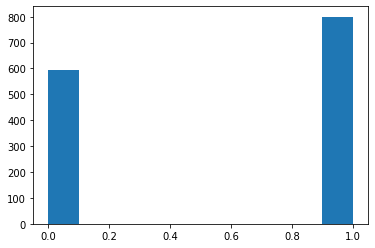

In [305]:
# plt.hist(original_student_performance[np.where(X == 1)])
plt.hist(student_performance[np.where(X == 1)])
plt.show()

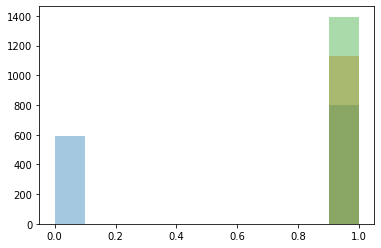

In [307]:
bspp_binary = best_student_performance_pred.copy()
# bspp_binary[bspp_binary > 0.8] = 1
# bspp_binary[bspp_binary < 0.8] = 0

bins = np.arange(0,1.1,0.1)
sns.distplot(y, kde=False, bins=bins)
sns.distplot(y_pred, kde=False, bins=bins)
sns.distplot(y_pred_binary, kde=False, bins=bins)
plt.show()

In [308]:
y_pred = best_student_performance_pred[np.where(X == 1)]
y_pred_binary = bspp_binary[np.where(X == 1)]

acc = 100*(np.logical_not(np.logical_xor(y, y_pred_binary)).sum())/len(y)
rmse = np.sqrt(np.power((y-y_pred), 2)).mean()

In [309]:
rmse

0.4261119081779053

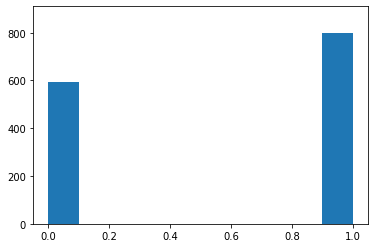

In [310]:
plt.hist(y)
plt.hist(y_pred)
plt.hist(y_pred_binary)
plt.show()

In [311]:
y = student_performance[np.where(X == 1)]
y_pred = best_student_performance_pred[np.where(X == 1)]
y_pred_binary = bspp_binary[np.where(X == 1)]

# best_student_performance_pred[best_student_performance_pred > 0.5] = 1
# best_student_performance_pred[best_student_performance_pred < 0.5] = 0

acc = 100*(np.logical_not(np.logical_xor(
    y, y_pred_binary)).sum())/len(y)
rmse = np.sqrt(np.power((y-y_pred), 2)).mean()

print("Accuracy: %.2f%%" % acc)
print("RMSE: %.2f" % rmse)

Accuracy: 57.39%
RMSE: 0.43


In [126]:
train_set.shape

(805, 3)

In [27]:
test_set.shape

(171, 3)

In [312]:
%%time
# Instantiate model
model_bkt = bkt.BKT()
model_pfa = pfa.PFA()
#model_tpfa = tpfa.TPFA()

CPU times: user 54 µs, sys: 0 ns, total: 54 µs
Wall time: 58.7 µs


In [313]:
model_bkt.fit(train_set, q_matrix)
model_pfa.fit(train_set, q_matrix)

/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [314]:
import copy

In [315]:
def get_results(model, data, learning_state=None):
    print("Results for model %s" % model)
#     data_arr = np.asarray(data)
    students = set(list(data[:,1]))
    rmse = 0
    n = 0
    score_df = []
    outcome_all = []
    predicted_proba = []
    
    if learning_state is None:
        learning_state = {}
    else:
        learning_state = copy.deepcopy(learning_state)
        
    for student in students:
        student_idx = np.where(data[:,1] == student)
        outcome = data[student_idx, 0].astype('int64')
        outcome_all += outcome.tolist()[0]
        question_id = data[student_idx, 2].astype('int64')
        try:
            timestamp = data[student_idx, 3]
            data_student = np.vstack((outcome, question_id, timestamp)).T.tolist()
        except IndexError:
            data_student = np.vstack((outcome, question_id)).T.astype('int64').tolist()
        # Already seen the student, get last learning state
        if student in learning_state.keys():
            predicted = model.predict_proba(data_student, q_matrix, learning_state[student])
        else:
            predicted = model.predict_proba(data_student, q_matrix)
        predicted_proba += predicted[:,1].tolist()
        s_ll, s_aic, s_bic, s_rmse, s_acc = model.score()
        fpr, tpr, _ = roc_curve(model.outcomes, predicted[:,1], pos_label=1)
        auc_score = auc(fpr, tpr)
        score_df.append({"student": student,
                         "AIC": s_aic,
                         "BIC": s_bic,
                         "RMSE": s_rmse,
                         "Acc": s_acc,
                         "n questions": model.n_questions,
                         "LL": s_ll,
                         "correct_outcome": np.where(outcome == 1)[1].shape[0],
                         "incorrect_outcome": np.where(outcome == 0)[1].shape[0],
                         "AUC": auc_score})
#         learning_state[student] = copy.deepcopy(model.get_learning_state())
        learning_state[student] = model.get_learning_state()
        
    return pd.DataFrame.from_dict(score_df), outcome_all, predicted_proba, learning_state

def print_scores(score, outcome, predicted):
    
    # RMSE
    rmse_train = np.sqrt((score['RMSE']**2*score['n questions']).sum()/score['n questions'].sum())
    rmse_avg = score['RMSE'].mean()
    rmse_std = score['RMSE'].std()
    print("RMSE de treino: %.2f" % rmse_train)
    print("RMSE médio: %.2f +- %.2f" % (rmse_avg, rmse_std))
    
    # Accuracy
    acc_train = (score['Acc']*score['n questions']).sum()/score['n questions'].sum()
    acc_avg = score['Acc'].mean()
    acc_std = score['Acc'].std()
    print("Acc de treino: %.2f" % acc_train)
    print("Acc médio: %.2f +- %.2f" % (acc_avg, acc_std))
    
    # AUC
    fpr, tpr, thresholds = roc_curve(outcome, predicted, pos_label=1)
    auc_score = auc(fpr, tpr)
    auc_avg = score['AUC'].mean()
    auc_std = score['AUC'].std()
    # Sensitivity = tpr = TP/(TP+FN)
    # Specificity = 1-fpr = TN/(TN+FP)
    # Youden's index = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
    J_stats = tpr - fpr
    J_opt_thresholds = thresholds[np.argmax(J_stats)]
    print('Youden\'s optimum threshold: %.2f' % J_opt_thresholds)
    print("AUC de treino: %.2f" % auc_score)
    print("AUC médio: %.2f +- %.2f" % (auc_avg, auc_std))
    estimated_outcome = np.where(np.asarray(predicted) > J_opt_thresholds, 1, 0)
    adjusted_acc = (estimated_outcome == np.asarray(outcome)).sum()/score['n questions'].sum()
    print("Adjusted Acc: %.2f" % adjusted_acc)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Results for model <spkit.bkt.BKT object at 0x7f7c78e3def0>
Results for model <spkit.pfa.PFA object at 0x7f7c78e3db38>
RMSE de treino: 0.46
RMSE médio: 0.45 +- 0.04
Acc de treino: 0.68
Acc médio: 0.69 +- 0.09
Youden's optimum threshold: 0.60
AUC de treino: 0.68
AUC médio: 0.65 +- 0.16
Adjusted Acc: 0.68


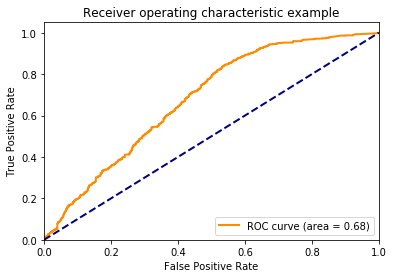

RMSE de treino: 0.48
RMSE médio: 0.48 +- 0.02
Acc de treino: 0.62
Acc médio: 0.62 +- 0.09
Youden's optimum threshold: 0.61
AUC de treino: 0.64
AUC médio: 0.58 +- 0.16
Adjusted Acc: 0.60


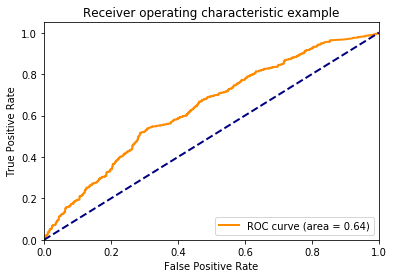

In [316]:
# Run model with train data to get students' updated learning state
score_bkt, outcome_bkt, predicted_bkt, learning_state_bkt = get_results(model_bkt, train_set)
score_pfa, outcome_pfa, predicted_pfa, learning_state_pfa = get_results(model_pfa, train_set)
#score_tpfa, outcome_tpfa, predicted_tpfa = get_results(model_tpfa, data_time)

print_scores(score_bkt, outcome_bkt, predicted_bkt)
print_scores(score_pfa, outcome_pfa, predicted_pfa)

Results for model <spkit.bkt.BKT object at 0x7f7c78e3def0>
RMSE de treino: 0.46
RMSE médio: 0.46 +- 0.06
Acc de treino: 0.68
Acc médio: 0.68 +- 0.16
Youden's optimum threshold: 0.70
AUC de treino: 0.58
AUC médio: 0.45 +- 0.05
Adjusted Acc: 0.49


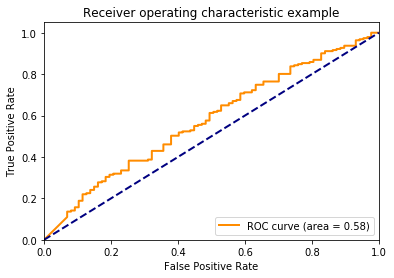

In [317]:
score_bkt, outcome_bkt, predicted_bkt, _ = get_results(model_bkt, test_set, learning_state_bkt)
print_scores(score_bkt, outcome_bkt, predicted_bkt)

Results for model <spkit.pfa.PFA object at 0x7f4bc3903fd0>
RMSE de treino: 0.42
RMSE médio: 0.42 +- 0.04
Acc de treino: 0.72
Acc médio: 0.73 +- 0.16
Youden's optimum threshold: 0.68
AUC de treino: 0.86
AUC médio: 0.79 +- 0.09
Adjusted Acc: 0.80


/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


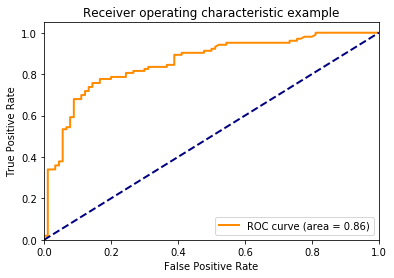

In [67]:
score_pfa, outcome_pfa, predicted_pfa, _ = get_results(model_pfa, test_set, learning_state_pfa)
print_scores(score_pfa, outcome_pfa, predicted_pfa)

In [195]:
# %load Create_simulation.py
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt

def simulated_data(n, a, q, e, c, num_view, datatype = None):
    ''' create simulated data
        n as number of student,
        a as number of attempt,
        p as number of problem,
        q as number of question,
        c as number of concept'''

    # create matrix for q and e
    quiz_concept = np.random.uniform(0,1, [c, q])
#     example_concept = np.random.uniform(0,1, [c, e])

    sumq = sum(quiz_concept)
#     sume = sum(example_concept)

    quiz_concept = quiz_concept/sumq # normalized q and e
#     example_concept = example_concept/sume

    # random create student activity sequence
    sequence_matrix = np.zeros([n,q])
    # For each student and question, draw the number of attempts
    for i in range(0, n):
        for j in range(0, q):
            tried_question = np.random.binomial(1,0.5,1)
            if tried_question:
                sequence_matrix[i, j] = np.random.randint(0, a+5)
            else:
                sequence_matrix[i, j] = 0
#     sequence_matrix = np.zeros([n,a])
#     if num_view == 1:
#         for i in range(0, n):
#             sequence_matrix[i, :] = np.random.choice(range(0, q), a)

    # create tensor t
    t = np.random.normal(0,1, [n, a, c]) # randomly create a tensor
    t1 = np.random.uniform(0,0.3, [n,c])   # create first slice of tensor as the student ability
    t[:, 0, :] = np.copy(t1)

    
    for i in range(1, a): #according to
        temp = np.copy(t1)
        for s in range(0,n):
            for q in range(q):
                q_attempts = sequence_matrix[s,q]
                if q_attempts == a:
                    forgetornot = np.random.uniform(0,0.5) # probability for random forget
                    if forgetornot >= 0.5: # if probability >= 0.5, then forget the knowledge instead of learning knowledge
                        random_forget = np.random.uniform(0,0.05,c)
                        temp[s, :] =  temp[s,:] - random_forget
                        temp[s, :][temp[s,:] < 0] = 0
                    else: # if not forget, then random increase the knowledge based on the question
                        temp[s,:] = t1[s,:] + np.multiply(quiz_concept[:,q], np.random.uniform(0, 0.8, c))
        t[:,i,:] = np.copy(temp)
        t1 = np.copy(temp)

    # quiz transpose, so that the shape of quiz and example be the [student, quiz, score]
    quiz = np.transpose(np.dot(t, quiz_concept), (0, 2, 1))
#     example = np.transpose(np.dot(t, example_concept), (0, 2, 1))
    
    return quiz, t, quiz_concept, sequence_matrix

#     final_q = np.zeros([n,q,a])
#     final_e = np.zeros([n,e,a])
#     for i in range(0,n):
#         for j in range(0,a):
#             activty = int(sequence_matrix[i,j])
#             if activty < q:
#                 final_q[i,activty,j] = np.copy(quiz[i,activty,j])

#     for i in range(0,n):
#         for j in range(0,a):
#             activty = int(sequence_matrix[i,j])
#             if activty >= q:
#                 activty = activty - q
#                 if datatype == 'Quiz_Discussion': # if the learning resource want to create is binary, then make example to be binary
#                     final_e[i, activty, j] = 1
#                 else:
#                     final_e[i,activty,j] = np.copy(example[i,activty,j])
#     return final_q, final_e, t, quiz_concept, example_concept

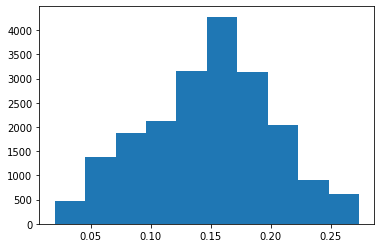

In [196]:
n = 100      # n as number of student
a = 20        # a as number of attempt
q = 10        # p as number of problem
e = 15        # q as number of question
c = 3         # c as number of concept
# k = 3         # k as number of latent student feature
# data_type = 'Quiz_Assignment' #simulation data type, assignment(continous) or discussion(binary)
# data_type = 'Quiz_Discussion'
# data_type = 'Quiz_Discussion_STQ'
# data_type = 'Quiz_Discussion_STQ_Thresholded'
data_type = 'Quiz_Only'
# data_type = 'Quiz_Only_Discussion_STQ'
# num_view = 1
num_view = 1


# quiz, example, t, quiz_concept, example_concept = simulated_data(n, a, q, e, c,num_view, data_type)
quiz, t, quiz_concept, sequence_matrix = simulated_data(n, a, q, e, c, num_view, data_type)

quiz_score_bf = []
for i in range(0, n):
    for j in range(0, q):
        for k in range(0, a):
            # print i, j, k
            # print quiz[i,j,k]
            if quiz[i, j, k] != 0:
                quiz_score_bf.append(quiz[i, j, k])

plt.hist(quiz_score_bf)
plt.show()

quiz[quiz > 0.15] = 1
quiz[quiz < 0.15] = 0


# quiz_score = []
# for i in range(0, n):
#     for j in range(0, q):
#         for k in range(0, a):
#             # print i, j, k
#             # print quiz[i,j,k]
#             if quiz[i, j, k] != 0:
#                 quiz_score.append(quiz[i,j,k])

# plt.hist(quiz_score)
# plt.show()

In [197]:
total = np.prod(quiz.shape)
total

20000

In [198]:
quiz.sum()

10320.0

In [199]:
sequence_matrix

array([[ 0., 15., 17., 14.,  5., 12.,  3.,  1.,  0.,  0.],
       [14.,  0.,  0.,  5., 14., 12.,  0.,  0.,  1., 19.],
       [13., 12., 24.,  0.,  0., 15., 16.,  0.,  0.,  0.],
       [ 0., 13.,  0.,  0.,  0., 13.,  0.,  0.,  0.,  0.],
       [ 8.,  0., 12.,  0., 12., 13.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 11., 22., 12.,  0.,  0., 10.,  0.,  4.],
       [ 0., 24.,  0., 17., 11., 22., 15.,  6.,  0.,  0.],
       [ 5., 16.,  0., 13.,  0.,  0.,  7., 21.,  0.,  0.],
       [11.,  0., 20., 16., 23.,  0., 11., 24., 14.,  0.],
       [ 9.,  0.,  0., 17.,  9.,  4.,  0.,  0.,  0., 20.],
       [ 0.,  0.,  0., 11.,  0.,  0.,  0.,  0., 12.,  0.],
       [15.,  0.,  0., 20.,  0.,  4.,  0., 16.,  0.,  2.],
       [ 7.,  3., 16., 15.,  0.,  0.,  0.,  0., 15.,  2.],
       [15.,  0., 17.,  0.,  4.,  0.,  0., 13.,  0., 19.],
       [13.,  0.,  0.,  0.,  5., 23., 12.,  0.,  0.,  0.],
       [ 0., 23.,  0., 21.,  1.,  0.,  0., 20.,  0.,  0.],
       [15.,  6., 19.,  0.,  6.,  0.,  0., 19., 18., 20.

In [200]:
X = np.zeros(quiz.shape)
# Substitute not observed items per None
for (student, question_id), attempt in np.ndenumerate(sequence_matrix):
    X[student, question_id, 0:min(20,int(attempt))] = 1
    
quiz[np.where(X == 0)] = None
quiz_original = quiz.copy()

### FDTF Tensor Factorization

In [227]:
def feedback_driven_tensor_factorization(student_performance, n_concepts=2, mu=0.1, init=3, max_iter=100):
    """ Student performance: 0 if incorrect, 1 if correct or None if not observed """
    
    # Get values from student performance tensor shape
    n_students, n_questions, n_attempts = student_performance.shape
    
    # Construct tensor X denoting when a student has or has not chosen to work on a problem
    X = np.ones(student_performance.shape)
    X[np.where(np.isnan(student_performance))] = 0
    # Complete student knowledge tensor with zero where is NaN
    student_performance[np.where(np.isnan(student_performance))] = 0
    
    # Create student knowledge tensor
    student_knowledge = np.zeros((n_students, n_concepts, n_attempts))

#     error_run = []
#     error_total_run = []
#     student_performance_pred_run = []
    best_error = 9999
    lambda1 = 0.0001
    
    # Several starts
    for run in range(init):
        print("Run: %d" % run)
#         error = []
        student_performance_pred_list = []

#         for attempt in range(n_attempts):
#             student_knowledge[:, :, attempt] = np.random.rand(n_students, n_concepts)
        q_matrix = np.random.rand(n_concepts, n_questions)
         # Impose non-negativity constraint
        q_matrix[q_matrix <= 0] = 0.01
        # Normalize rows to sum one
        row_sums = q_matrix.sum(axis=0, keepdims=True)
        if not (np.any(q_matrix.sum(axis=0))):
            raise RuntimeError("Q Matrix with empty row")
        q_matrix = q_matrix / row_sums

        student_performance_pred = np.zeros(student_performance.shape)
        for i in range(max_iter):
            # Phase 2: learning
            # Update T: T = 2*(T_{t-1}) + 2*((1-T_{t-1})/(1+exp(-mu*X_{t}*Q'))) - 1
            # For T0 user T-1 as 0
            student_knowledge[:, :, 0] = (2/(1+np.exp(-mu*np.dot(X[:,:,0], q_matrix.T)))-1)
#             print(student_knowledge[0,:,0])
#             break
#         break
            for attempt in range(1, n_attempts):
                student_knowledge[:, :, attempt] = (2*student_knowledge[:, :, attempt-1]) + \
                2*(1-student_knowledge[:, :, attempt-1])/(1+np.exp(-mu*np.dot(X[:,:,attempt], q_matrix.T))) - 1
#                 print(student_knowledge[0,:,attempt])
                
            
            # Phase 1: prediction
            # Update Q: Q = (T'T)^(-1)T'Y = T^(-1)Y
            # (T'T)^(-1)
            student_knowledge_transposed = np.zeros((n_concepts, n_concepts, n_attempts))
            for attempt in range(n_attempts):
                student_knowledge_transposed[:, :, attempt] = np.dot(student_knowledge[:, :, attempt].T, 
                                                                     student_knowledge[:, :, attempt])
                
            student_knowledge_transposed = student_knowledge_transposed.sum(axis=2)
#             try:
            student_knowledge_transposed_inv = np.linalg.pinv(student_knowledge_transposed+lambda1)
#             except np.linalg.LinAlgError:
#                 return student_knowledge, X, q_matrix, student_knowledge_transposed_inv, TY
            
            # T'Y
            TY = np.zeros((n_concepts, n_questions, n_attempts))
            for attempt in range(n_attempts):
                TY[:, :, attempt] = np.dot(student_knowledge[:, :, attempt].T, 
                                           student_performance[:, :, attempt])
            TY = TY.sum(axis=2)
            
            ## TODO: add regularization parameters (lambda)
            # Q = (T'T)^(-1)T'Y
            q_matrix = np.dot(student_knowledge_transposed_inv, TY)
            # Impose non-negativity constraint
            q_matrix[q_matrix < 0] = 0
            # Normalize rows to sum one
            row_sums = q_matrix.sum(axis=0, keepdims=True)
            if not (np.all(row_sums)):
                raise RuntimeError("Q Matrix with empty row")
#                 print("Q Matrix with empty row")
#                 return q_matrix
            q_matrix = q_matrix / row_sums
            
            # Y = TQ
            for attempt in range(n_attempts):
                student_performance_pred[:, :, attempt] = np.dot(student_knowledge[:, :, attempt], q_matrix)
                
            
            diff = np.zeros((n_students, n_questions, n_attempts))
            for attempt in range(n_attempts):
                diff[:, :, attempt] = student_performance[:, :, attempt] - student_performance_pred[:, :, attempt]
            # Frobenius norm (norm-2)
            error = np.sqrt(np.sum(np.power(diff, 2)))
#             error.append(np.sqrt(np.sum(np.power(diff, 2))))
            if error < best_error:
                best_student_performance_pred = student_performance_pred.copy()
                best_student_knowledge = student_knowledge.copy()
                best_q_matrix = q_matrix.copy()
                best_error = error
            
#             student_performance_pred_iter = student_performance_pred.copy()
#             student_performance_pred_list.append(student_performance_pred_iter)
#         student_performance_pred_run.append(student_performance_pred_list)
#         error_run.append(error)
#         error_total_run.append(error[-1])
                
#     return np.asarray(student_performance_pred_run), np.asarray(error_run), error_total_run
    if best_error == 9999:
        raise RuntimeError("Could not converge")
    return best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error
#     return (np.asarray(student_performance_pred_run), np.asarray(error_run), error_total_run, 
#             best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error)

In [31]:
def predict(previous_student_knowledge, q_matrix, X):
    # Get values from student performance tensor shape
    current_student_knowledge = np.zeros(previous_student_knowledge.shape)
    current_student_knowledge = (2*previous_student_knowledge) + \
                2*(1-previous_student_knowledge)/(1+np.exp(-mu*np.dot(X, q_matrix.T))) - 1
    next_student_performance = np.dot(current_student_knowledge, q_matrix)
    return next_student_performance

In [178]:
best_student_knowledge.shape

(25, 3, 36)

In [183]:
for student in test_set:
    outcome, s_idx, q_idx = item
    psk = best_student_knowledge[s_idx, :, -1]
    this_X = test_X[s_idx, :, -1]
    break

In [192]:
test_X.shape

(25, 20, 49)

In [177]:
test_set

array([[ 1,  9,  7],
       [ 1,  9,  7],
       [ 1,  9,  9],
       [ 0,  9, 10],
       [ 1,  9, 11],
       [ 1,  9, 11],
       [ 1,  9, 13],
       [ 1,  9, 15],
       [ 0,  9,  0],
       [ 0,  9,  1],
       [ 0,  9,  5],
       [ 0,  9,  6],
       [ 0,  9,  8],
       [ 0,  9,  8],
       [ 0,  9, 12],
       [ 0,  9, 14],
       [ 0,  9, 16],
       [ 0,  9, 16],
       [ 0,  9, 17],
       [ 0,  9, 18],
       [ 0,  9, 19],
       [ 0,  9, 19],
       [ 1,  8, 10],
       [ 1,  8, 10],
       [ 1,  8, 11],
       [ 1,  8, 13],
       [ 0,  8, 13],
       [ 0,  8, 15],
       [ 1,  8,  0],
       [ 1,  8,  0],
       [ 1,  8,  1],
       [ 0,  8,  1],
       [ 1,  8,  5],
       [ 0,  8,  6],
       [ 1,  8,  6],
       [ 1,  8,  8],
       [ 1,  8,  8],
       [ 1,  8, 12],
       [ 0,  8, 14],
       [ 1,  8, 16],
       [ 1,  8, 16],
       [ 1,  8, 17],
       [ 1,  8, 18],
       [ 0,  8, 18],
       [ 1,  8, 19],
       [ 1, 12,  4],
       [ 1, 12,  7],
       [ 1, 1

In [201]:
%%time
best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error = feedback_driven_tensor_factorization(
    quiz, n_concepts=3, init=100, max_iter=1000)
best_error

CPU times: user 4min 18s, sys: 51 ms, total: 4min 18s
Wall time: 4min 18s


125.53504195397154

### Simulation 1 - Student Performance is the exact multiplication of  Q Matrix and Student Knowledge

In [75]:
N_CONCEPTS = 2
N_QUESTIONS = 5
N_STUDENTS = 10
N_ATTEMPTS = 3

In [76]:
def generate_sample(noise=0):
    DENSITY = 0.8

    # Create sparse q_matrix and normalize it to sum 1
    q_matrix = sparse.rand(N_CONCEPTS, N_QUESTIONS, DENSITY).todense()
    row_sums = q_matrix.sum(axis=0)
    while not(np.all(row_sums)):
        q_matrix = sparse.rand(N_CONCEPTS, N_QUESTIONS, DENSITY).todense()
        row_sums = q_matrix.sum(axis=0)
    q_matrix = q_matrix / row_sums

    student_knowledge = np.zeros((N_STUDENTS, N_CONCEPTS, N_ATTEMPTS))
    for attempt in range(N_ATTEMPTS):
        student_knowledge[:, :, attempt] = sparse.rand(N_STUDENTS, N_CONCEPTS, DENSITY).todense()

    student_performance = np.zeros((N_STUDENTS, N_QUESTIONS, N_ATTEMPTS))
    for attempt in range(N_ATTEMPTS):
        student_performance[:, :, attempt] = np.dot(student_knowledge[:, :, attempt], q_matrix)
        
    if noise:
        noise = np.random.normal(0, noise, (N_STUDENTS, N_QUESTIONS, N_ATTEMPTS))
        student_performance = student_performance + noise
        
    return student_performance

In [109]:
student_performance = generate_sample()

In [128]:
# student_performance_pred_run, error_run, error_total_run = feedback_driven_tensor_factorization(
#     student_performance, n_concepts=2, init=1, max_iter=4)
best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error = feedback_driven_tensor_factorization(
    student_performance, n_concepts=2, init=1, max_iter=4)
best_error

7.179852801172138

### Simulation 2 - Student Performance is the multiplication of Q Matrix and Student Knowledge plus noise

In [129]:
student_performance = generate_sample(0.5)
# Add random None
random_questions = np.random.randint(0, N_QUESTIONS, int(0.2*total))
random_students = np.random.randint(0, N_QUESTIONS, int(0.2*total))
random_attempts = np.random.randint(0, N_ATTEMPTS, int(0.2*total))

student_performance[random_questions, random_students, random_attempts] = None

In [130]:
# student_performance_pred_run, error_run, error_total_run = feedback_driven_tensor_factorization(
#     student_performance, n_concepts=2, init=3, max_iter=5)
best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error = feedback_driven_tensor_factorization(
    student_performance, n_concepts=2, init=3, max_iter=5)
best_error

7.773789328315481

### Simulation 3 - Student Performance contains only zeros and ones

In [131]:
student_performance = generate_sample(0.5)

In [132]:
student_performance[student_performance > 0.5] = 1
student_performance[student_performance < 0.5] = 0

In [133]:
# Add random None
random_questions = np.random.randint(0, N_QUESTIONS, int(0.2*total))
random_students = np.random.randint(0, N_QUESTIONS, int(0.2*total))
random_attempts = np.random.randint(0, N_ATTEMPTS, int(0.2*total))

student_performance[random_questions, random_students, random_attempts] = None

In [135]:
best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error = feedback_driven_tensor_factorization(
    student_performance, n_concepts=2, init=3, max_iter=100)
best_error

9.969006306135684

In [136]:
best_student_performance_pred[best_student_performance_pred > 0.5] = 1
best_student_performance_pred[best_student_performance_pred < 0.5] = 0

In [137]:
acc = 100*(np.logical_not(np.logical_xor(
    student_performance, best_student_performance_pred)).sum())/(
    student_performance.shape[0]*student_performance.shape[1]*student_performance.shape[2])
print("Accuracy: %.2f%%" % acc)

Accuracy: 28.67%


/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/numpy/linalg/linalg.py:1974: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less


Error in 44 for noise 0.35


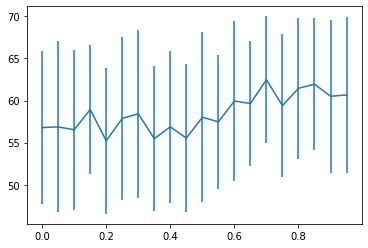

CPU times: user 1min 5s, sys: 16.7 ms, total: 1min 5s
Wall time: 1min 5s


In [147]:
%%time
accs = []
accs_std = []

for noise in np.arange(0, 1, 0.05):
    accs_run = []
    for run in range(50):
        # Generate sample and approximate values to 0 and 1
        student_performance = generate_sample(noise)
        student_performance[student_performance > 0.5] = 1
        student_performance[student_performance < 0.5] = 0
        
        # Add random None
        random_questions = np.random.randint(0, N_QUESTIONS, int(0.1*total))
        random_students = np.random.randint(0, N_QUESTIONS, int(0.1*total))
        random_attempts = np.random.randint(0, N_ATTEMPTS, int(0.1*total))

        student_performance[random_questions, random_students, random_attempts] = None
        

#         Run tensor factorization
        try:
            best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error = feedback_driven_tensor_factorization(
            student_performance, n_concepts=2, init=3, max_iter=50)
        except RuntimeError:
            print("Error in run %d for noise %.2f" % (run, noise))
            continue
        

#         Get best run results
        best_student_performance_pred[best_student_performance_pred > 0.5] = 1
        best_student_performance_pred[best_student_performance_pred < 0.5] = 0
        

#         Calculate accuracy
        acc = 100*(np.logical_not(np.logical_xor(
            student_performance, best_student_performance_pred)).sum())/(
            student_performance.shape[0]*student_performance.shape[1]*student_performance.shape[2])
        accs_run.append(acc)

    accs.append(np.asarray(accs_run).mean())
    accs_std.append(np.asarray(accs_run).std())
    
plt.errorbar(np.arange(0, 1, 0.05), accs, yerr=accs_std)
plt.show()

In [485]:
diff = np.zeros((N_QUESTIONS, N_STUDENTS, N_ATTEMPTS))
for attempt in range(N_ATTEMPTS):
    diff[:, :, attempt] = student_performance[:, :, attempt] - best_student_performance_pred[:, :, attempt]

In [486]:
np.sqrt(np.sum(np.power(diff, 2)))

4.898979485566356